# Image Analysis

In [1]:
import os
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_dir = "../data/oct24_clean/"

games = pd.read_csv(data_dir + "games.csv")
genres = pd.read_csv(data_dir + "genres_translated.csv")
spy = pd.read_csv(data_dir + "steamspy_insights.csv") 
prom = pd.read_csv(data_dir + "promotional.csv")

In [3]:
# df = games.loc[:, ["app_id", "name"]]
# df = df.merge(spy.loc[:, ["app_id", "concurrent_users_yesterday"]], how="inner", on="app_id")
# df = df.merge(genres, how="right", on="app_id")

# top_n = 100
# top = df.sort_values(by="concurrent_users_yesterday", ascending=False).groupby("genre").head(top_n)
# counts = top.genre.value_counts()
# top = top[top["genre"].map(counts) >= top_n]

# df = pd.DataFrame({"app_id": top.app_id.unique()})
# 

df = pd.read_csv(data_dir + "ge-10_concurrent-users.csv")
df

,app_id
0,1126290
1,2643960
2,865680
3,22500
4,880950
...,...
6169,1172470
6170,1203220
6171,570
6172,578080


## Load Images

In [41]:
import cv2

def load_image(image_path):
    image = cv2.imread(image_path)  # Loads image in BGR format
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    return image

image_dir = "../data/img/header"

images = []
keys = dict()

for i, app_id in enumerate(df.app_id):
    images.append(load_image(f"{image_dir}/{app_id}.jpg"))
    keys[app_id] = i

In [43]:
def show_images(imgs):
    fig, axes = plt.subplots(3, 2, figsize=(8, 6))
    for i, ax in enumerate(axes.reshape(-1)):
        ax.imshow(imgs[i])
    plt.tight_layout()

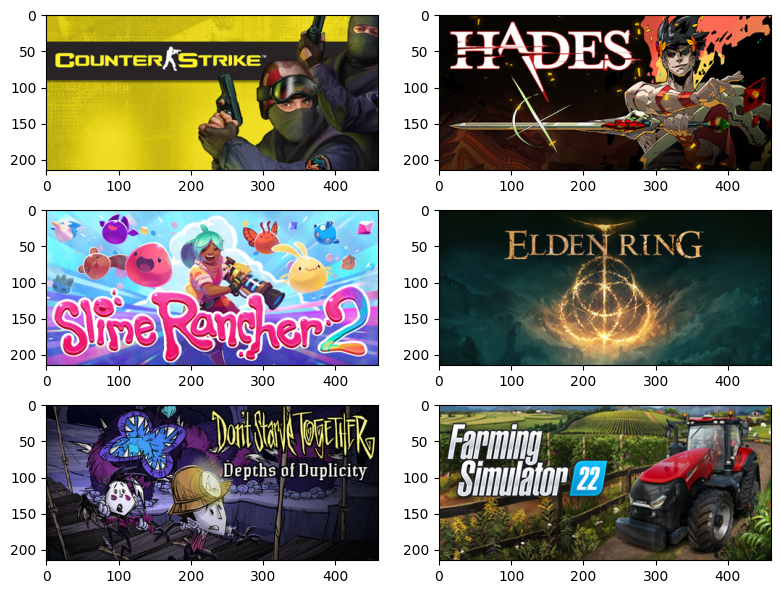

In [44]:
# example_ids = [10, 1366540, 322330, 238460,]
example_ids = [10, 1145360, 1657630, 1245620, 322330, 1248130]

# example_ids = np.random.choice(df.app_id, size=(6,))
show_images([images[keys[id]] for id in example_ids])

## Dominant Colors (K-Means Quantization)

***Computation***

In [ ]:
from sklearn.cluster import MiniBatchKMeans  # Faster than standard KMeans
from scipy.spatial import cKDTree  # Faster than sklearn NearestNeighbors
from joblib import Parallel, delayed  # Parallel processing

def find_top_colors(image_array, k):
    """Find k dominant colors using MiniBatchKMeans for speed."""
    kmeans = MiniBatchKMeans(n_clusters=k, n_init=3, batch_size=1000)  
    kmeans.fit(image_array)
    return kmeans.cluster_centers_

def replace_colors(image_array, top_colors):
    """Replace each pixel with the closest top color using cKDTree."""
    tree = cKDTree(top_colors)
    _, indices = tree.query(image_array)  # Find closest colors
    return top_colors[indices]

def rgb_to_lab(image_array):
    """Convert RGB image to LAB color space for better clustering."""
    return cv2.cvtColor(image_array.astype(np.uint8), cv2.COLOR_RGB2LAB).reshape(-1, 3)

def process_image(img, k):
    """Pipeline for a single image."""
    flat_lab = rgb_to_lab(img)
    top_colors = find_top_colors(flat_lab, k)
    return top_colors

In [55]:
# Process images in parallel
k = 8
knn_colors = Parallel(n_jobs=-1, backend="loky")(
    delayed(process_image)(img, k) for img in images)

Quantization: k=8


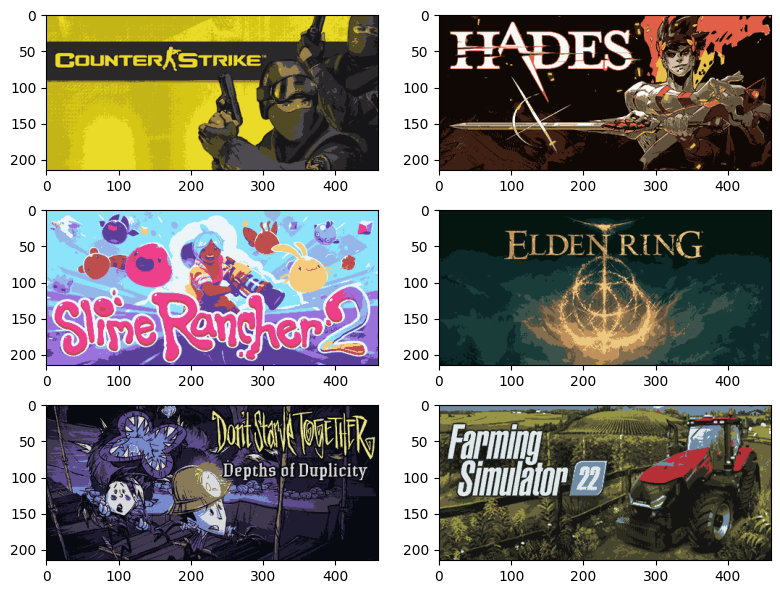

In [56]:
knn_images = []

for img_idx in example_ids:
    flat_lab = rgb_to_lab(images[keys[img_idx]]).reshape(-1, 3)
    top_colors = knn_colors[keys[img_idx]]

    knn_image = replace_colors(flat_lab, top_colors)
    knn_image = knn_image.reshape(images[keys[img_idx]].shape).astype(np.uint8)
    knn_image = cv2.cvtColor(knn_image, cv2.COLOR_LAB2RGB) # Back to RGB

    knn_images.append(knn_image)

print(f"Quantization: k={k}")
show_images(knn_images)

## Color Distribution (Histogram Analysis)

***Computation***

In [11]:
# Compute color histograms for all images in the dataset
color_histograms = [[] for _ in range(3)]

for img in images:
    # Split channels
    r_hist = cv2.calcHist([img], [2], None, [256], [0, 256]).flatten()
    g_hist = cv2.calcHist([img], [1], None, [256], [0, 256]).flatten()
    b_hist = cv2.calcHist([img], [0], None, [256], [0, 256]).flatten()
    
    # Normalize histograms (optional)
    r_hist /= r_hist.sum()
    g_hist /= g_hist.sum()
    b_hist /= b_hist.sum()
    
    # Store data
    color_histograms[0].append(r_hist)
    color_histograms[1].append(g_hist)
    color_histograms[2].append(b_hist)

# Convert lists to NumPy arrays
for i in range(3):
    color_histograms[i] = np.array(color_histograms[i])
color_histograms = np.array(color_histograms)
color_histograms = np.transpose(color_histograms, axes=[1, 0, 2])

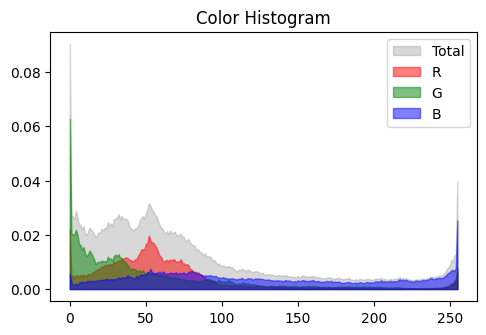

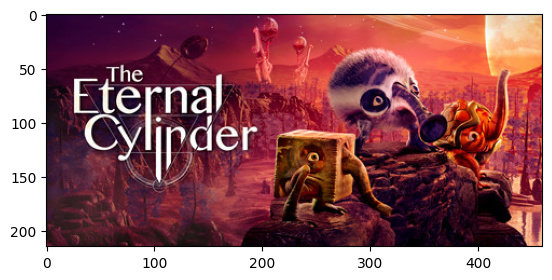

In [14]:
img_idx = 2

y = color_histograms[img_idx]
x = np.arange(y.shape[1])
y_tot = y.sum(axis=0)

plt.figure(figsize=(5.5, 3.5))
plt.fill_between(x, y_tot, color="gray", alpha=0.3, label="Total")
plt.fill_between(x, y[0], color="red", alpha=0.5, label="R")
plt.fill_between(x, y[1], color="green", alpha=0.5, label="G")
plt.fill_between(x, y[2], color="blue", alpha=0.5, label="B")
plt.title("Color Histogram")
plt.legend()
plt.show()

plt.imshow(images[img_idx])

## Structural Analysis (PCA)

***Computation***

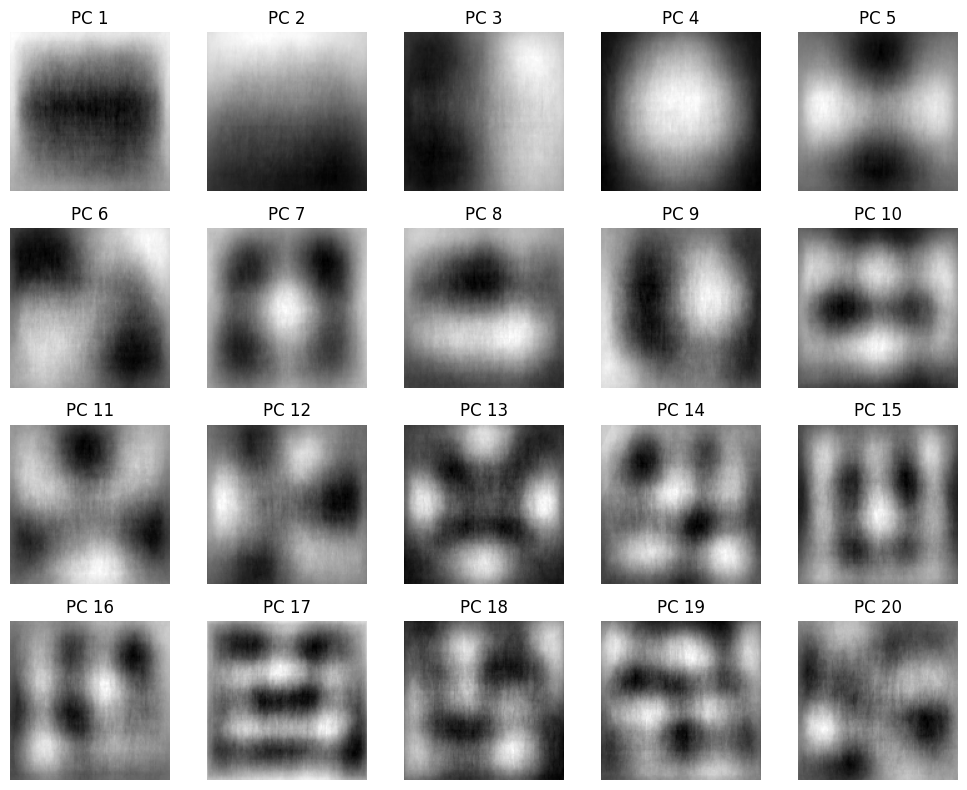

In [75]:
from sklearn.decomposition import PCA

EIG_SIZE = (128, 128)
EIG_COMPONENTS = 20

# Convert images to grayscale and flatten
eig = []
eig_keys = []

for key, img in images.items():
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    resized = cv2.resize(gray, EIG_SIZE)          # Resize to fixed size
    flattened = resized.flatten()                 # Flatten into 1D vector
    eig.append(flattened)
    eig_keys.append(key)

# Stack all images into a matrix (each row is an image)
image_matrix = np.stack(eig)

# Apply PCA
pca = PCA(n_components=EIG_COMPONENTS)
pca.fit(image_matrix)

# Visualize the top principal components (Eigenimages)
fig, axes = plt.subplots(EIG_COMPONENTS // 5, 5, figsize=(10, 8))
for i, ax in enumerate(axes.flat):
    if i >= EIG_COMPONENTS:
        break
    eigenimage = pca.components_[i].reshape(EIG_SIZE)  # Reshape back to image
    ax.imshow(eigenimage, cmap='gray')
    ax.set_title(f'PC {i+1}')
    ax.axis('off')
plt.tight_layout()
plt.show()

# Project images onto principal components
pca_features = pca.transform(image_matrix)

In [78]:
eig_keys

[1126290,
 2643960,
 865680,
 22500,
 880950,
 1551160,
 1135830,
 2071430,
 2070990,
 223810,
 2928700,
 1289340,
 1285670,
 1292180,
 559310,
 1338330,
 2366530,
 487000,
 486810,
 2577760,
 2954260,
 1101070,
 2195390,
 858940,
 345090,
 463060,
 1426010,
 3249680,
 771950,
 779640,
 388270,
 2081400,
 671800,
 1146310,
 2618360,
 1966220,
 975270,
 976390,
 329440,
 1586800,
 1914580,
 978680,
 2138090,
 1634150,
 898720,
 2174320,
 398850,
 732370,
 3174920,
 598550,
 212010,
 1149440,
 2916180,
 2060170,
 910880,
 2169830,
 2263920,
 679110,
 469920,
 1501970,
 444970,
 629650,
 269110,
 1157740,
 1828970,
 1160220,
 1018020,
 2960590,
 529240,
 1902710,
 457730,
 2328740,
 2328710,
 1456200,
 844590,
 1357260,
 1913210,
 15700,
 385380,
 2248900,
 720250,
 964130,
 2054810,
 3107590,
 2125540,
 3008190,
 838630,
 563200,
 1859360,
 402620,
 910320,
 914010,
 32110,
 638200,
 264140,
 1504150,
 2102490,
 354240,
 1708710,
 835430,
 1026420,
 1227780,
 1230170,
 1233070,
 256330,
